# Predicting Insurance Total Claims Amount

### Readme:

Thank you for your interest.

This notebook contains analysis for predicting the total claims amount from an insurance dataset "train.csv".  The resulting regularized linear regression model is used to build the final prediction model for my Insight Data Science project called AutoBroker (http://autobroker.site).  The full model contains proprietary information from my project consulting partner so it is not shared publicly.  Please feel free to contact me for more information.

Author: Saul Lee

2018-07

In [64]:
# import the libaries and modules for the analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression, LassoCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pickle
import seaborn as sns
%matplotlib inline

Load in Functions used for this analysis

In [65]:
def encoder(inArray):
    """purpose: encode categorical data into numerical values
    
    """
    le = LabelEncoder()
    le.fit(inArray)
    encoded = le.transform(inArray)
    
    return encoded

def encodePD(inPD):
    """encode the categorical columns in a data frame into numerical values
    
    """
    outPD = pd.DataFrame()
    for key,val in inPD.iteritems():
        # check if the column is numeric, if not, encode the data
        if inPD[key].dtype == 'O':
            outPD[key] = encoder(val)
        else:
            outPD[key] = val
    
    return outPD

def sortCoef(feature_names,coefs):
    """ function to sort model coefficients by magnitude

    feature_names = column names corresponding to the features
    coefs = feature coefficients from the fitted model
    """
    
    coefs_abs = np.abs(coefs)
    total = np.sum(coefs_abs)
    coefs_normalized =  coefs_abs / total
    coefs_normalized = np.round(coefs_normalized,2)
        
    temp_list = sorted(zip(feature_names,coefs_normalized),key = lambda x: x[1],reverse = True)
    sorted_list = []
    for row in temp_list:
        if row[1] > 0:
            sorted_list.append(row)
    
    return sorted_list  

def sortCorr(inCorr,thresh=0.5):
    """sort and return value pairs with in a correlation matrix where abs(value) above threshold
    
    """
    corr_list = []
    for rowIndex,row in corr.iterrows():
        for key,val in row.iteritems():
            if (abs(val) >= thresh) and (rowIndex != key):
                corr_list.append((rowIndex,key,round(val,3)))
    
    corr_list = sorted(corr_list,key = lambda x: x[2],reverse = True)
    
    return corr_list

def vectorizer(inArray):
    """vectorizer to do one-hot encoding
    
    """
    lbb = LabelBinarizer()
    lbb.fit(inArray)
    vectorized = lbb.transform(inArray)
    
    return vectorized,lbb

## 1. Data Loading, Exploration, and Preprocessing

### 1.1 Load and examine the data

In [66]:
# load in the data
raw_data = pd.read_csv('../train.csv')

In [67]:
raw_data.head()

,Customer,Country,State Code,State,Claim Amount,Response,Coverage,Education,Effective To Date,EmploymentStatus,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Claim Reason,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,US,KS,Kansas,276.351928,No,Basic,Bachelor,2/24/11,Employed,...,5,0,1,Corporate Auto,Corporate L3,Collision,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,US,NE,Nebraska,697.953590,No,Extended,Bachelor,1/31/11,Unemployed,...,42,0,8,Personal Auto,Personal L3,Scratch/Dent,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,US,OK,Oklahoma,1288.743165,No,Premium,Bachelor,2/19/11,Employed,...,38,0,2,Personal Auto,Personal L3,Collision,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,US,MO,Missouri,764.586183,No,Basic,Bachelor,1/20/11,Unemployed,...,65,0,7,Corporate Auto,Corporate L2,Collision,Call Center,529.881344,SUV,Medsize
4,HB64268,US,KS,Kansas,281.369258,No,Basic,Bachelor,2/3/11,Employed,...,44,0,1,Personal Auto,Personal L1,Collision,Agent,138.130879,Four-Door Car,Medsize


In [68]:
# show the column headings
raw_data.columns

Index(['Customer', 'Country', 'State Code', 'State', 'Claim Amount',
       'Response', 'Coverage', 'Education', 'Effective To Date',
       'EmploymentStatus', 'Gender', 'Income', 'Location Code',
       'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy Type', 'Policy', 'Claim Reason',
       'Sales Channel', 'Total Claim Amount', 'Vehicle Class', 'Vehicle Size'],
      dtype='object')

From visual examination of the data, the columns State and StateCode contain the same information.  Drop the State column.  The Country column only contains one category 'US', the column will be dropped.

In [69]:
# drop non-necessary columns

# do not need the customer IDs
raw_data = raw_data.drop('Customer',axis=1)

# do not need the Country column since it's all in the US
print(raw_data['Country'].value_counts())
raw_data = raw_data.drop('Country',axis=1)

# State Code and State contain duplicate information, drop State
raw_data = raw_data.drop('State',axis=1)

US    9134
Name: Country, dtype: int64


### 1.2 Visualize the data with correlation and scatter plots

In [70]:
# there are many categorical data columns, encode the categories to numerical values so that we can generate a 
# correlations matrix
raw_data_encoded = encodePD(raw_data)
raw_data_encoded.head()

,State Code,Claim Amount,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Claim Reason,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,1,276.351928,0,0,0,47,1,0,56274,1,...,5,0,1,0,2,0,0,384.811147,5,1
1,3,697.953590,0,1,0,24,4,0,0,1,...,42,0,8,1,5,3,0,1131.464935,0,1
2,4,1288.743165,0,2,0,41,1,0,48767,1,...,38,0,2,1,5,0,0,566.472247,5,1
3,2,764.586183,0,0,0,12,4,1,0,1,...,65,0,7,0,1,0,2,529.881344,3,1
4,1,281.369258,0,0,0,52,1,1,43836,0,...,44,0,1,1,3,0,0,138.130879,0,1


In [71]:
# calculate the correlation matrix
corr = raw_data_encoded.corr(method= 'pearson')

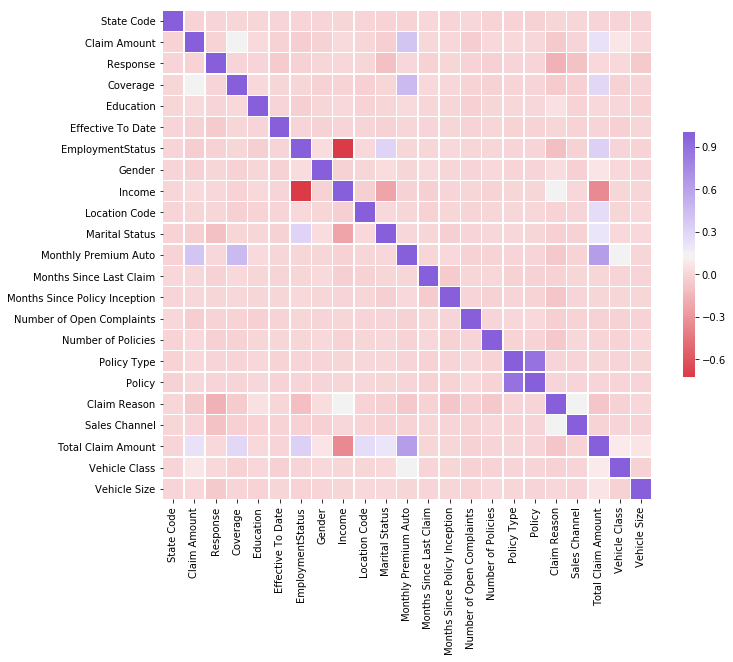

In [72]:
## Pearson Correlation Matrix ##
f, ax = plt.subplots(figsize=(11,9))

#generate a custom diverging colormap
cmap = sns.diverging_palette(10, 275, as_cmap=True)

#draw heatmap w/mask & corect aspect ratio
sns.heatmap(corr, cmap=cmap, square=True, xticklabels=True, yticklabels=True, linewidth = .5, cbar_kws={"shrink": .5}, ax=ax)

In [73]:
# check for correlated variables above 0.7
sortCorr(corr,0.7)

[('Policy Type', 'Policy', 0.88),
 ('Policy', 'Policy Type', 0.88),
 ('EmploymentStatus', 'Income', -0.727),
 ('Income', 'EmploymentStatus', -0.727)]

The correlation plot shows that there may be some correlated variables, namely, EmploymentStatus-Income (-0.727) and Policy Type-Policy (0.88).  If linear models are used, need to consider L1 regularization.

Explore the data by plotting scatter plots

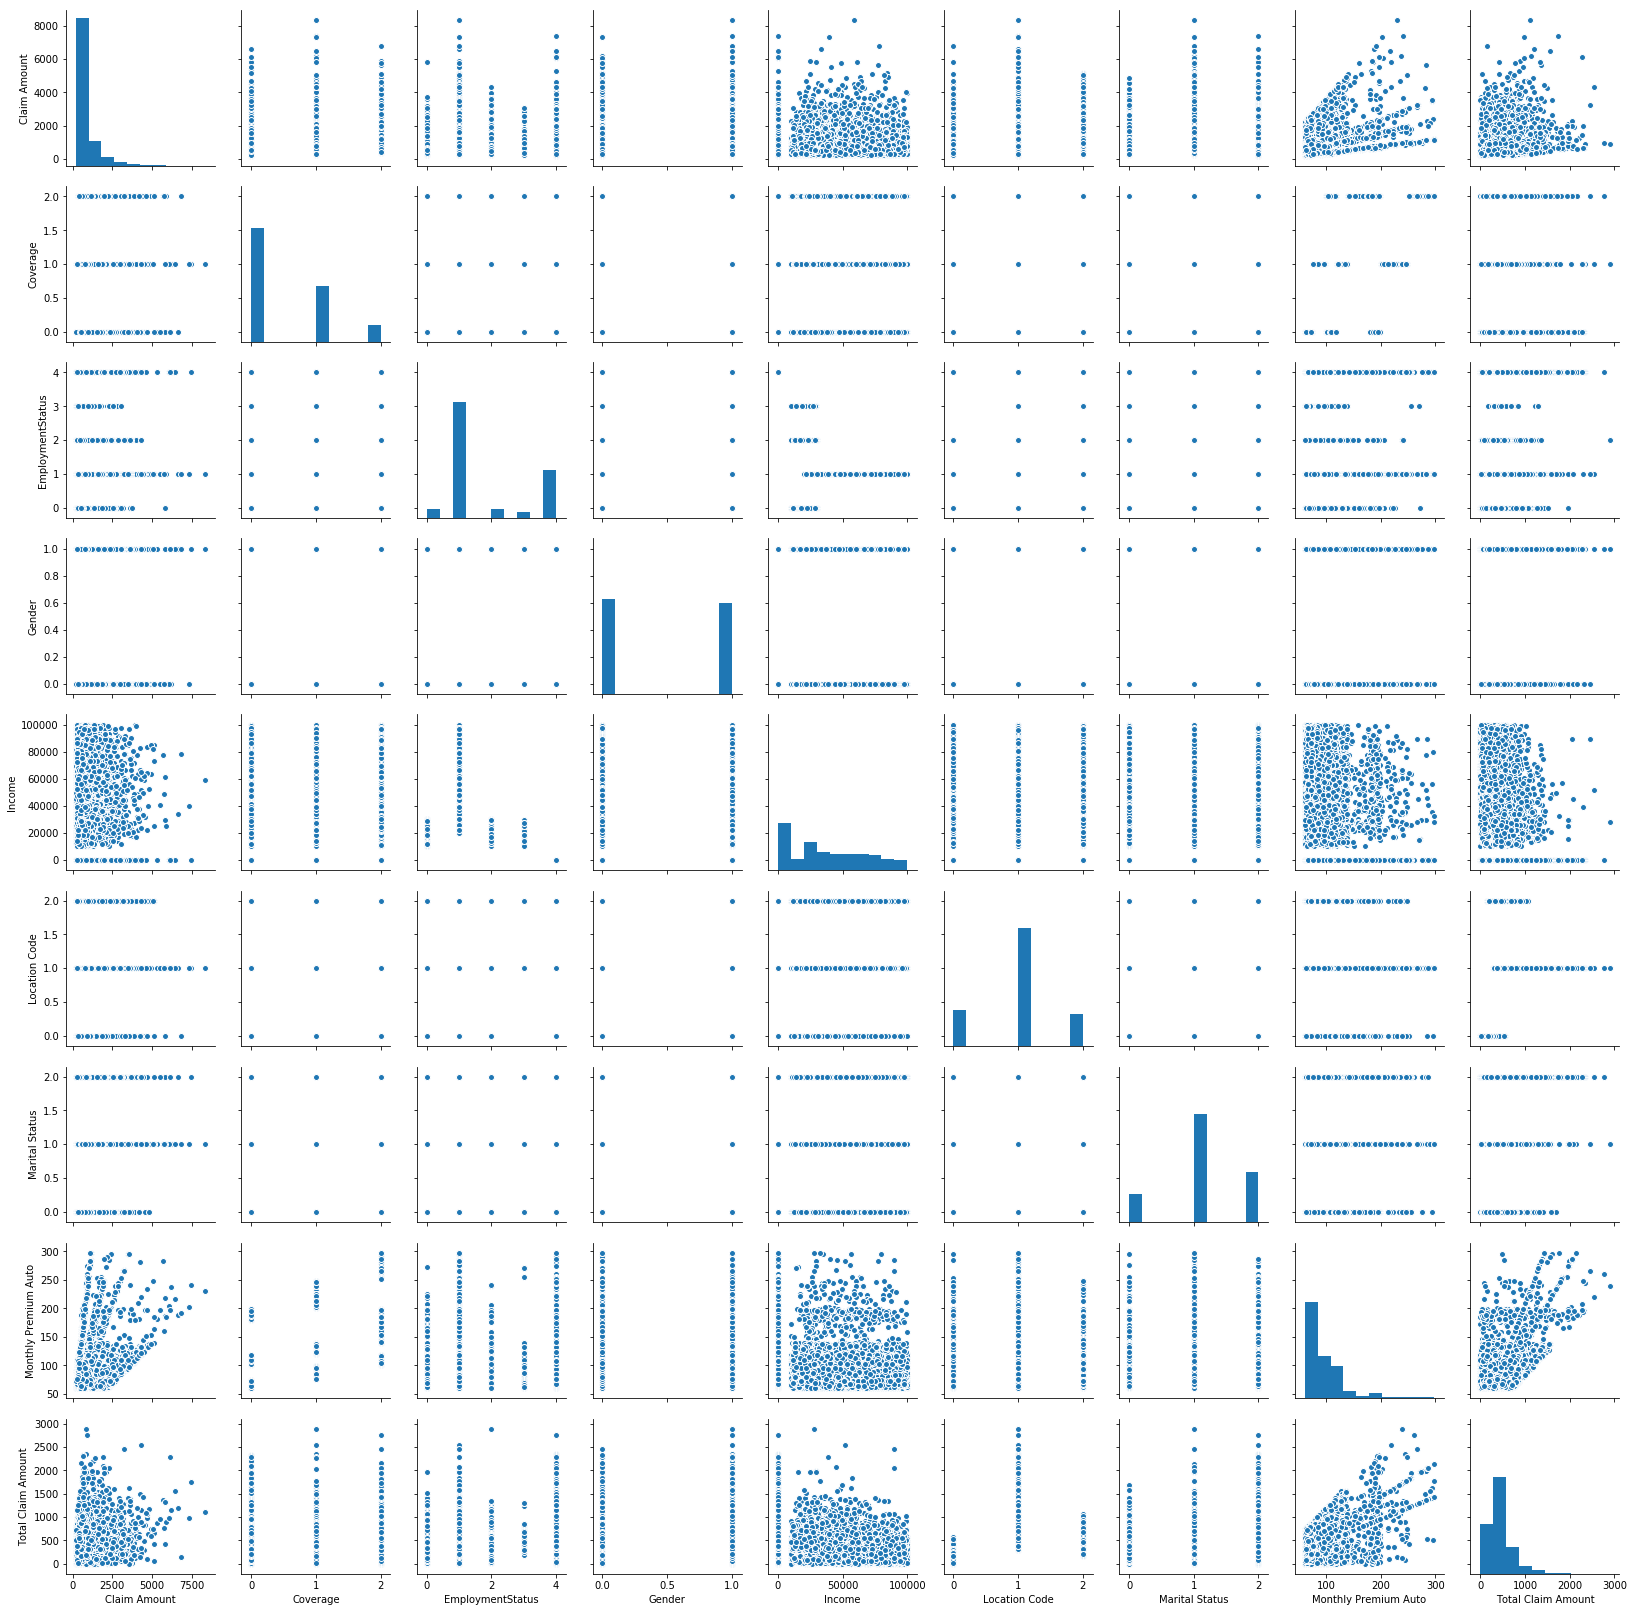

In [74]:
# do scatter plot of the data.  Since there are many columns, select the columns of most relevance to 
# Total claims from the correlation matrix
cols = ['Claim Amount','Coverage','EmploymentStatus','Gender','Income',
        'Location Code','Marital Status','Monthly Premium Auto','Total Claim Amount']
sns.pairplot(raw_data_encoded, x_vars=cols, y_vars=cols)

### 1.3 Preprocessing Data

In [75]:
# assign the y variable total claim and remove from the dataframe
total_claims = raw_data['Total Claim Amount']
y = np.array(total_claims)

To fit the model, convert the categorical data into one-hot encoded columns.

In [76]:
# assign the X variables
full_features = raw_data
full_features = full_features.drop('Total Claim Amount',axis=1)

# convert the categorial data to one-hot encoding
full_features = pd.get_dummies(full_features)
full_features.head()

,Claim Amount,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,State Code_IA,State Code_KS,State Code_MO,...,Sales Channel_Web,Vehicle Class_Four-Door Car,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Large,Vehicle Size_Medsize,Vehicle Size_Small
0,276.351928,56274,69,32,5,0,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,697.953590,0,94,13,42,0,8,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,1288.743165,48767,108,18,38,0,2,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,764.586183,0,106,18,65,0,7,0,0,1,...,0,0,0,0,1,0,0,0,1,0
4,281.369258,43836,73,12,44,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0


In [77]:
# Generate the X features array and perform feature normalization
X = np.array(full_features)

# Feature normalize
X_scaler = StandardScaler()
X_scaler.fit(X)
X = X_scaler.transform(X)

In [78]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [79]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (6850, 123)
Training Labels Shape: (6850,)
Testing Features Shape: (2284, 123)
Testing Labels Shape: (2284,)


## 2. Model Fitting using Lasso Regression

Since the correlation matrix revealed some correlated variables, let's try to fit the data using a linear regression model with L1 regularization (Lasso).  In the first pass, fit a lasso model using all of the remaining features.  Then examine all of the coefficients to identfy the most relevant features.

### 2.1 Fitting Model Parameters

In [80]:
# setup the Lasso model with cross validation
from sklearn.linear_model import LassoCV
alpha_vals = [0.0001, 0.0003, 0.001,0.03,0.1,0.3,1,3,10,30,100]
num_folds = 10
reg_full = LassoCV(alphas=alpha_vals,cv=num_folds,n_jobs=-1)

In [81]:
reg_full.fit(X_train,y_train)

LassoCV(alphas=[0.0001, 0.0003, 0.001, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100],
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=-1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [82]:
# print some relevant data from the fitting
print("Alpha: {}".format(reg_full.alpha_))

Alpha: 1.0


From the cross validation, the best alpha value is 1.0.  Refit the model using alpha = 1.0

### 2.2 Refit the model using the selected alpha

In [83]:
reg_full = Lasso(alpha=1)
reg_full.fit(X_train,y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [84]:
# generate the predicted y-values
y_pred = reg_full.predict(X_test)
y_pred

array([184.83675045, 467.35704087, 465.67696891, ...,  15.49286316,
       256.61348915, 568.50226006])

In [85]:
print("Score: {:.2f}".format(reg_full.score(X_test,y_test)))

# mean absolute error for the linear regression model
y_model_mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {:0.2f}".format(y_model_mae))

Score: 0.76
Mean Absolute Error: 94.42


### 2.3 Visualize the model fitting results

Text(0.5,1,'Total Claim Amount ($)')

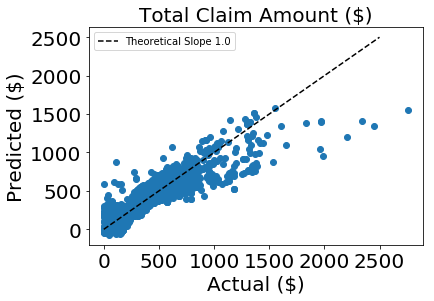

In [86]:
# Scatter plot of predicted vs. actual
plt.scatter(y_test,y_pred)
plt.xlabel('Actual ($)',fontsize=20)
plt.xticks(size='20')
plt.ylabel('Predicted ($)',fontsize=20)
plt.yticks(size='20')
plt.plot([0,2500],[0,2500],'k--',label='Theoretical Slope 1.0')
plt.legend()
plt.title('Total Claim Amount ($)',fontsize=20)

Text(0.5,1,'Residuals vs. Predicted Values')

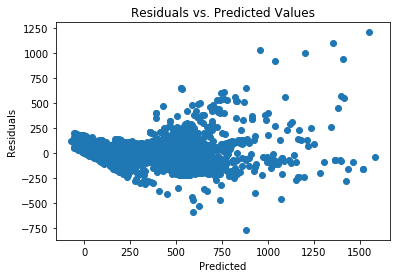

In [87]:
# Plot the residuals vs the predicted
residuals = y_test - y_pred
plt.scatter(y_pred,residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

Text(0.5,1,'Distribution of Residuals')

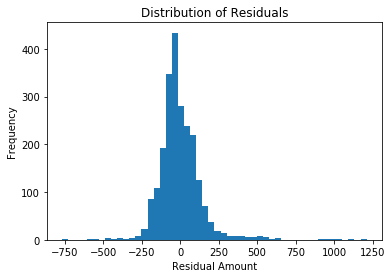

In [88]:
# plot the histogram of the residuals
plt.hist(residuals, bins=50)
plt.xlabel('Residual Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

Text(0.5,1,'Normalized Quantile Plot')

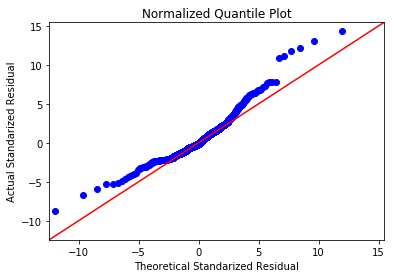

In [89]:
# Generate Normalized Quantile Plot
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from scipy import stats
QQ = ProbPlot(residuals,stats.t,fit=True)
QQ.qqplot(line='45')
plt.xlabel('Theoretical Standarized Residual')
plt.ylabel('Actual Standarized Residual')
plt.title('Normalized Quantile Plot')

Calculate the mean absolute error and compar it to a naive model.  For the naive model, assume we pick the mean y values from the training set

In [90]:
# mean absolute error for the linear regression model
y_model_mae = mean_absolute_error(y_test, y_pred)
y_model_mae

94.42323948941579

In [91]:
# mean absolute error for the naive model, which assumes y = mean(y_train)
y_naive = np.ones_like(y_test) * np.mean(y_train)
y_naive_mae = mean_absolute_error(y_test,y_naive)
y_naive_mae

204.5971044282478

In [92]:
# percentage improvement
print("The linear regression model improves the MAE by {:0.2f} % over the naive model" \
      .format(100 * (y_naive_mae - y_model_mae)/(y_naive_mae)))

The linear regression model improves the MAE by 53.85 % over the naive model


Text(0.5,1,'Mean Absolute Error')

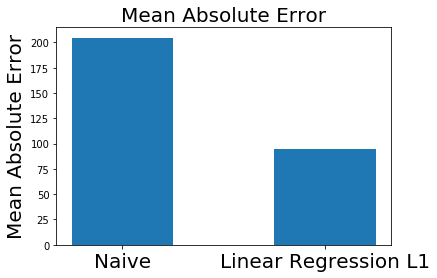

In [93]:
plt.bar(['Naive','Linear Regression L1'],[y_naive_mae,y_model_mae],width=0.5)
plt.xticks(fontsize = 20)
plt.ylabel('Mean Absolute Error',fontsize = 20)
plt.title('Mean Absolute Error',fontsize = 20)

In [94]:
# sorted the coefficients by normalized absolute magnitude
sortCoef(full_features.columns,reg_full.coef_)

[('Monthly Premium Auto', 0.32),
 ('Location Code_Rural', 0.17),
 ('Location Code_Suburban', 0.15),
 ('EmploymentStatus_Unemployed', 0.06),
 ('Marital Status_Single', 0.06),
 ('Vehicle Class_Luxury Car', 0.02),
 ('Income', 0.01),
 ('Response_No', 0.01),
 ('Coverage_Extended', 0.01),
 ('Education_Doctor', 0.01),
 ('Education_High School or Below', 0.01),
 ('Effective To Date_1/24/11', 0.01),
 ('Effective To Date_1/7/11', 0.01),
 ('Effective To Date_2/24/11', 0.01),
 ('Effective To Date_2/4/11', 0.01),
 ('EmploymentStatus_Employed', 0.01),
 ('EmploymentStatus_Medical Leave', 0.01),
 ('Gender_F', 0.01),
 ('Policy_Special L1', 0.01),
 ('Claim Reason_Hail', 0.01),
 ('Vehicle Class_Luxury SUV', 0.01)]

### From Full Linear Regression, these following features where shown to have higher importance to predicting total claims:

1. Monthly Premium Auto, 0.32
2. Location Code, 0.32 (Rural 0.17 + Suburban 0.15)
3. Employment Status 0.08 (Unemployeed 0.06 + Employed 0.01 + Medial Leave 0.01)
4. Marital Status, 0.06 (Single 0.06)
5. Vehicle Class, 0.03 (Luxury car 0.02 + Luxury SUV 0.01)


Text(0.5,1,'Linear Regression of Total Claim Amount')

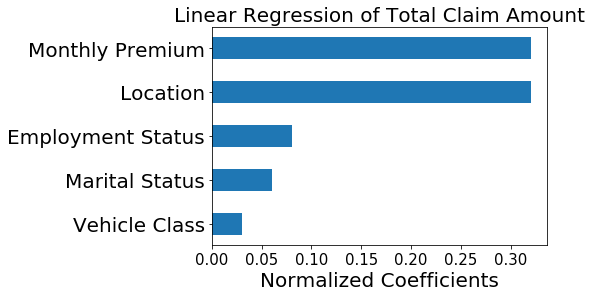

In [95]:
# Generate horizontal bar plot the top normalized coefficients
x_barh = ['Monthly Premium','Location','Employment Status','Marital Status','Vehicle Class']
y_barh = np.array([0.32,0.32,0.08,0.06,0.03])
fontsize = 20
plt.barh(x_barh[::-1],y_barh[::-1],height=0.5)
plt.yticks(size = fontsize,ha='right')
plt.xticks(size = 15)
plt.xlabel('Normalized Coefficients',fontsize = fontsize)
plt.title('Linear Regression of Total Claim Amount',fontsize = fontsize)

## 3. Fit a New Model with the Top 5 Features

In [96]:
# build X features matrix
features = raw_data[['Monthly Premium Auto','Location Code','EmploymentStatus','Marital Status','Vehicle Class']]

The pandas get_dummies function is a fast way of doing one-hot encoding, however, need more robust function to vectorize the data to deploy to the web-app

In [97]:
# use the custom defined vectorizer to one_hot encode the data
[location_vectorized,location_binarizer] = vectorizer(features['Location Code'])
[employment_vectorized,employment_binarizer] = vectorizer(features['EmploymentStatus'])
[maritalstatus_vectorized,maritalstatus_binarizer] = vectorizer(features['Marital Status'])
[vehicle_class_vectorized,vehicle_class_binarizer] = vectorizer(features['Vehicle Class'])

In [98]:
# build the features_list column names
features_list = ['Monthly Premium Auto']
features_list.extend(location_binarizer.classes_)
features_list.extend(employment_binarizer.classes_)
features_list.extend(maritalstatus_binarizer.classes_)
features_list.extend(vehicle_class_binarizer.classes_)
features_list

['Monthly Premium Auto',
 'Rural',
 'Suburban',
 'Urban',
 'Disabled',
 'Employed',
 'Medical Leave',
 'Retired',
 'Unemployed',
 'Divorced',
 'Married',
 'Single',
 'Four-Door Car',
 'Luxury Car',
 'Luxury SUV',
 'SUV',
 'Sports Car',
 'Two-Door Car']

In [99]:
# build the X array
X = np.hstack((np.reshape(np.array(features['Monthly Premium Auto']),(-1,1)),
               location_vectorized,
               employment_vectorized,
               maritalstatus_vectorized,
               vehicle_class_vectorized
              ))

X

array([[ 69,   0,   1, ...,   0,   0,   1],
       [ 94,   0,   1, ...,   0,   0,   0],
       [108,   0,   1, ...,   0,   0,   1],
       ...,
       [ 85,   0,   1, ...,   0,   0,   0],
       [ 96,   0,   1, ...,   0,   0,   0],
       [ 77,   0,   1, ...,   0,   0,   1]])

In [100]:
# Feature normalize
X_scaler = StandardScaler()
X_scaler.fit(X)
X = X_scaler.transform(X)

/Users/sl1885/anaconda/envs/insight/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/sl1885/anaconda/envs/insight/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [101]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [102]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (6850, 18)
Training Labels Shape: (6850,)
Testing Features Shape: (2284, 18)
Testing Labels Shape: (2284,)


In [103]:
# setup the Lasso model with alpha determine from LassoCV
reg = Lasso(alpha=1)

In [104]:
reg.fit(X_train,y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [105]:
y_pred = reg.predict(X_test)
y_pred

array([172.03009628, 457.00854922, 497.46109657, ...,   9.57425853,
       255.72784994, 589.91478041])

In [106]:
# print some relevant data from the fitting
print("Score: {:.2f}".format(reg.score(X_test,y_test)))

# mean absolute error for the linear regression model
y_model_mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {:0.2f}".format(y_model_mae))

Score: 0.76
Mean Absolute Error: 94.82


In [107]:
# sorted the coefficients by normalized absolute magnitude
sortCoef(features_list,reg.coef_)

[('Monthly Premium Auto', 0.38),
 ('Rural', 0.2),
 ('Suburban', 0.19),
 ('Unemployed', 0.08),
 ('Single', 0.07),
 ('Luxury Car', 0.03),
 ('Employed', 0.01),
 ('Medical Leave', 0.01),
 ('Luxury SUV', 0.01)]

Text(0.5,1,'Total Claim Amount ($)')

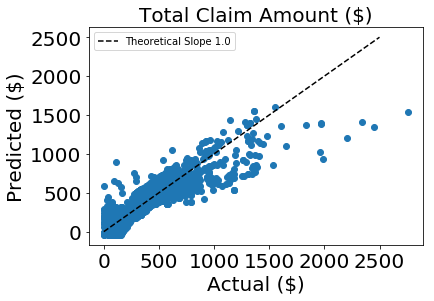

In [108]:
# Scatter plot of predicted vs. actual
plt.scatter(y_test,y_pred)
plt.xlabel('Actual ($)',fontsize=20)
plt.xticks(size='20')
plt.ylabel('Predicted ($)',fontsize=20)
plt.yticks(size='20')
plt.plot([0,2500],[0,2500],'k--',label='Theoretical Slope 1.0')
plt.legend()
plt.title('Total Claim Amount ($)',fontsize=20)

Text(0.5,1,'Residuals vs. Predicted Values')

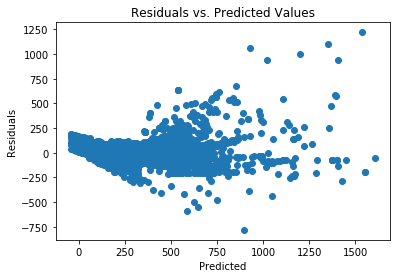

In [109]:
# Plot the residuals vs the predicted
residuals = y_test - y_pred
plt.scatter(y_pred,residuals)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

Text(0.5,1,'Distribution of Residuals')

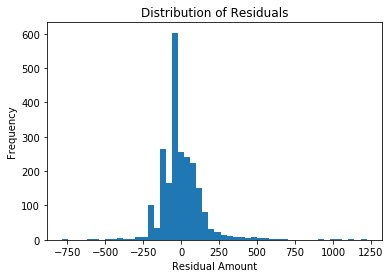

In [110]:
# plot the histogram of the residuals
plt.hist(residuals, bins=50)
plt.xlabel('Residual Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

Text(0.5,1,'Normalized Quantile Plot')

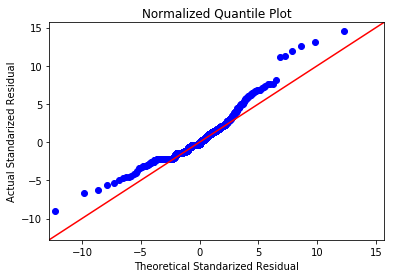

In [111]:
# Generate Normalized Quantile Plot
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from scipy import stats
QQ = ProbPlot(residuals,stats.t,fit=True)
QQ.qqplot(line='45')
plt.xlabel('Theoretical Standarized Residual')
plt.ylabel('Actual Standarized Residual')
plt.title('Normalized Quantile Plot')

Summary: Using the top five coefficients, we can predict the total claims amount.

## 4. Pickle the Model

In [112]:
# pickle the current model to file
models = [reg]
with open('custom_models.pickle', 'wb') as f1:
    pickle.dump(models,f1)

In [113]:
# pickle the scalers to file
scalers = [X_scaler]
with open('custom_scalers.pickle', 'wb') as f2:
    pickle.dump(scalers,f2)

In [114]:
# pickle the binarizers to file
binarizers = [location_binarizer, employment_binarizer, maritalstatus_binarizer, vehicle_class_binarizer]
with open('custom_binarizers.pickle', 'wb') as f3:
    pickle.dump(binarizers,f3)

In [115]:
# unpickle the model to double check
with open('custom_models.pickle', 'rb') as f1:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data_models = pickle.load(f1)

In [116]:
# unpickle the scalers to double check
with open('custom_scalers.pickle', 'rb') as f2:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data_scalers = pickle.load(f2)

In [117]:
# unpickle the binarizers to double check
with open('custom_binarizers.pickle', 'rb') as f3:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data_binarizers = pickle.load(f3)

## 5. Summary

I was able to fit linear regression model with L1 regularization to predict the total claim amount from an auto insurance data set.  L1 Regularization was select to reduct the effects of correlated features.  From the plots of the residuals vs. predicted values, the errors are not equally distributed which suggest a skew in the data.  This is also observed in the QQ plots.  Overall, the linear regression model predicts the data with an R^2 value of 0.76 with a 53% improvement in accuracy over the naive model.  Some future steps perhaps to remove outliers, find the appropriate transformations to remove the skew in the data, and try other models such as Random Forest.

This model should provide a good proof-of-concept for the web-app (http://autobroker.site) solution that I developed with our consulting partner.

## Appendix. Statistical Analysis

In [118]:
import statsmodels.api as sm
from scipy import stats

In [119]:
X_stat = sm.add_constant(X)
X

array([[-0.70392465, -0.49077899,  0.76193849, ..., -0.49472552,
        -0.23654547,  1.9603709 ],
       [ 0.02269103, -0.49077899,  0.76193849, ..., -0.49472552,
        -0.23654547, -0.51010755],
       [ 0.42959581, -0.49077899,  0.76193849, ..., -0.49472552,
        -0.23654547,  1.9603709 ],
       ...,
       [-0.23889062, -0.49077899,  0.76193849, ..., -0.49472552,
        -0.23654547, -0.51010755],
       [ 0.08082028, -0.49077899,  0.76193849, ..., -0.49472552,
        -0.23654547, -0.51010755],
       [-0.47140763, -0.49077899,  0.76193849, ..., -0.49472552,
        -0.23654547,  1.9603709 ]])

In [120]:
# Fit regression model
results = sm.OLS(y, X).fit()

In [121]:
# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     203.2
Date:                Tue, 10 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:35:24   Log-Likelihood:                -68883.
No. Observations:                9134   AIC:                         1.378e+05
Df Residuals:                    9120   BIC:                         1.379e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           166.6000      9.941     16.759      0.0

In [122]:
features_list

['Monthly Premium Auto',
 'Rural',
 'Suburban',
 'Urban',
 'Disabled',
 'Employed',
 'Medical Leave',
 'Retired',
 'Unemployed',
 'Divorced',
 'Married',
 'Single',
 'Four-Door Car',
 'Luxury Car',
 'Luxury SUV',
 'SUV',
 'Sports Car',
 'Two-Door Car']